# Graft, Reassemble, Answer delta, Neighbour sensitivity, Training delta (GRANT)

GRANT has been created by Wagtail Labs to remove the guesswork in using tree based models, assisting the creation of faster, more accurate models with satisfying explanations. It provides a deep understanding of the model's internal behaviour, shows prediction sensitivities, and helps data scientists improve inaccurate predictions.

For a detailed introduction to GRANT visit [wagtaillabs.com](https://wagtaillabs.com).

# Set up

Test on:
 - python 3.6.9 (default, Jul 17 2020, 12:50:27) \n[GCC 8.4.0]
 - pandas 1.0.5
 - numpy 1.18.5
 - sklearn 0.22.2.post1
 - matplotlib 3.2.2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import _tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import check_random_state
import copy
import itertools 
import datetime
import gc

First up we'll define some helper functions that are used to train the model.

In [2]:
def train_forest(df, split_point):
  train_features = df.drop(['Metered Generation (Total; MWh)'], axis = 1).head(len(df)-split_point)
  train_labels = df['Metered Generation (Total; MWh)'].head(len(df)-split_point)
  val_features = df.drop(['Metered Generation (Total; MWh)'], axis = 1).tail(split_point)
  val_labels = df['Metered Generation (Total; MWh)'].tail(split_point)

  rf = RandomForestRegressor(n_estimators = 2, random_state = 42, max_depth = 10)
  rf.fit(train_features.drop('Trading Interval', axis=1), train_labels)

  return [rf, train_features, train_labels, val_features, val_labels]

def check_predictions(rf, train_features, train_labels, val_features, val_labels):
  fig,axes  = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
  fig.tight_layout(pad=6.0)
  predictions_plot(rf, train_features, train_labels, axes[0,0])
  predictions_plot(rf, val_features, val_labels, axes[0,1])
  predictions_plot(rf, train_features.tail(7*48), train_labels.tail(7*48), axes[1,0])
  predictions_plot(rf, val_features.head(7*48), val_labels.head(7*48), axes[1,1])

def predictions_plot(rf, features, labels, ax):
  predictions = rf.predict(features.drop('Trading Interval', axis=1))
  errors = abs(predictions - labels)
  title='MAE:' + str(round(np.mean(errors), 2)) + \
        ' MAX_AE:' + str(round(np.max(abs(errors)), 2)) + \
        ' RMSE:' + str(round(np.sqrt(np.mean(np.square(errors))), 2))
  pd.DataFrame({'labels': labels, 
                'predictions': predictions, 
                'Trading Interval': features['Trading Interval']}).plot(title=title, ax=ax, x='Trading Interval')

Next let's download some sample data for us to explore. Electricity data has been chosen because it is a non-stationary timeseries that is difficult for many modelling techniques to accurately capture.

In [3]:
%%time
df = pd.read_csv('http://data.wa.aemo.com.au/datafiles/load-summary/load-summary-2010.csv', parse_dates=['Trading Date','Trading Interval'])
for i in range(2011, 2020):
  df=df.append(pd.read_csv('http://data.wa.aemo.com.au/datafiles/load-summary/load-summary-'+str(i)+'.csv', 
                           parse_dates=['Trading Date','Trading Interval']))
df=df[['Trading Interval', 'Metered Generation (Total; MWh)']].dropna()

df.insert(len(df.columns), 'hour', df['Trading Interval'].dt.hour + df['Trading Interval'].dt.minute/60)
df.insert(len(df.columns), 'weekday', df['Trading Interval'].dt.weekday)
df.insert(len(df.columns), 'month', df['Trading Interval'].dt.month)
df.insert(len(df.columns), 'year', df['Trading Interval'].dt.year)

max_temp = pd.read_csv('https://drive.google.com/uc?authuser=0&id=1CHwEwl6A4uqRq_2Q6rtcoICqEMehYR1X&export=download')
min_temp = pd.read_csv('https://drive.google.com/uc?authuser=0&id=1HJV8HtzRlTG_Tn12gUEPemqNt-4E-QWo&export=download')
temp = max_temp.merge(min_temp, left_on=['Year','Month','Day'], right_on=['Year','Month','Day']).dropna()
temp = temp[['Year','Month','Day','Maximum temperature (Degree C)', 'Minimum temperature (Degree C)']]
temp['max_lag1'] = temp['Maximum temperature (Degree C)'].shift(periods=1)
temp['min_lag1'] = temp['Minimum temperature (Degree C)'].shift(periods=1)
temp['max_lag2'] = temp['Maximum temperature (Degree C)'].shift(periods=2)
temp['min_lag2'] = temp['Minimum temperature (Degree C)'].shift(periods=2)
temp['max_lead1'] = temp['Maximum temperature (Degree C)'].shift(periods=-1)
temp['min_lead1'] = temp['Minimum temperature (Degree C)'].shift(periods=-1)
df.insert(len(df.columns), 'day', df['Trading Interval'].dt.day)
df = df.merge(temp, left_on=['year','month','day'], right_on=['Year','Month','Day']).drop(['day', 'Year', 'Month', 'Day'], axis=1)

solar_output = pd.read_csv('https://drive.google.com/uc?authuser=0&id=1LKKPydF9Owcof9z2hSWjNQjQiy-tCLYa&export=download')
solar_output = solar_output[['Year','Month','Day','Daily global solar exposure (MJ/m*m)']]
df.insert(len(df.columns), 'day', df['Trading Interval'].dt.day)
df = df.merge(solar_output, left_on=['year','month','day'], right_on=['Year','Month','Day']).drop(['day', 'Year', 'Month', 'Day'], axis=1)

CPU times: user 972 ms, sys: 186 ms, total: 1.16 s
Wall time: 50.6 s


As expected, the Random Forest does a great job at capturing the training data and an ok job at predicting the validation data.

CPU times: user 2.45 s, sys: 142 ms, total: 2.6 s
Wall time: 2.51 s


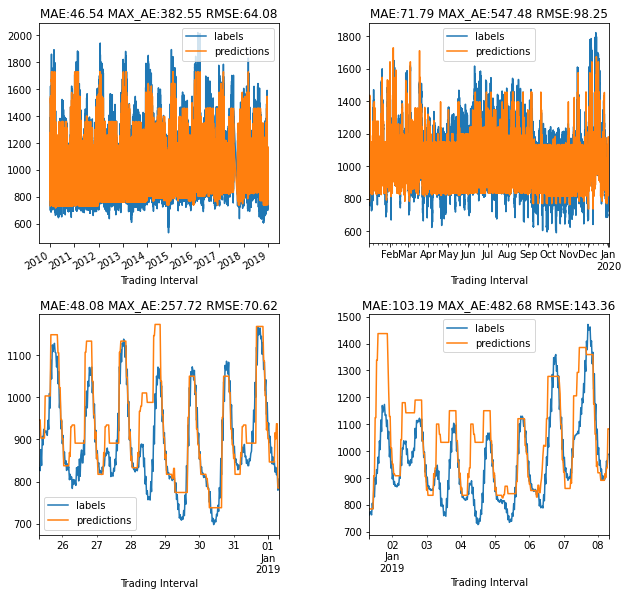

In [4]:
%%time
[rf, train_features, train_labels, val_features, val_labels] = train_forest(df, 365*48)
check_predictions(rf, train_features, train_labels, val_features, val_labels)

Now let's get started with GRANT.

# Graft

**Graft** converts the many trees of the model into a single set of rules, specifically capturing all of the decision boundaries of each prediction. Precisely describing the model and allowing it to be explored in an intuitive, meaningful way.

First step is to convert each of the decision trees in the model into a dataframe that shows exactly how it works.

*tree_to_dataframe* works by starting with a single record that spans from minus to plus infinity in all explanatory fields, then recursively splits the record based on the values of the decision tree. The return value is then added when the leaf of the decision tree is detected.

The scikit-learn implementation of Random Forest in this demo uses 32-bit values, so care must be taken to avoid rounding errors when comparing with 64-bit values later on.

The code below was adapted from a [stack overflow post](https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree), thanks to @paulkernfeld and @NirIzr.

In [5]:
%%time

def tree_to_dataframe(tree, feature_names, position):
    tree_ = tree.tree_
    feature_name = [
      feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
      for i in tree_.feature
    ]

    data = [[val for pair in zip([-float('Inf') for feature in feature_names], 
                                 [float('Inf') for feature in feature_names]) for val in pair] + [0]]
    columns = [val for pair in zip(["<" + feature for feature in feature_names], 
                                   [feature + "<=" for feature in feature_names]) for val in pair] + ["value"]
    splits = pd.DataFrame(data, columns = columns).astype('float32')
    df = tree_to_dataframe_recurse(splits, tree_, feature_name, 0, position)
    return(df)

def tree_to_dataframe_recurse(splits, tree_, feature_name, node, position):
  if tree_.feature[node] != _tree.TREE_UNDEFINED:
    splits_left = splits.copy()
    splits_right = splits.copy()
    name = feature_name[node]
    threshold = tree_.threshold[node]

    if threshold < threshold.astype('float32'):
      threshold = threshold - (threshold.astype('float32') - threshold)
    if threshold > threshold.astype('float32'):
      threshold = threshold + (threshold.astype('float32') - threshold)

    splits_left[name+"<="] = threshold.astype('float32')
    splits_left = tree_to_dataframe_recurse(splits_left, tree_, feature_name, tree_.children_left[node], position)
    splits_right["<"+name] = threshold.astype('float32')
    splits_right = tree_to_dataframe_recurse(splits_right, tree_, feature_name, tree_.children_right[node], position)

    splits = pd.concat([splits_left, splits_right])
  else:
    splits["value"] = tree_.value[node]
    splits["leaf"] = str(position) + "-" + str(node)
  return(splits)
    
tree = rf.estimators_[0]
feature_names = train_features.drop('Trading Interval', axis=1).columns
df0 = tree_to_dataframe(tree, feature_names, 0)

CPU times: user 1.67 s, sys: 9.26 ms, total: 1.68 s
Wall time: 1.68 s


Let's have a quick look at the result.

In [6]:
df0

,<hour,hour<=,<weekday,weekday<=,<month,month<=,<year,year<=,<Maximum temperature (Degree C),Maximum temperature (Degree C)<=,<Minimum temperature (Degree C),Minimum temperature (Degree C)<=,<max_lag1,max_lag1<=,<min_lag1,min_lag1<=,<max_lag2,max_lag2<=,<min_lag2,min_lag2<=,<max_lead1,max_lead1<=,<min_lead1,min_lead1<=,<Daily global solar exposure (MJ/m*m),Daily global solar exposure (MJ/m*m)<=,value,leaf
0,-inf,0.75,-inf,inf,-inf,inf,-inf,2013.5,-inf,inf,-inf,18.849998,-inf,17.65,-inf,8.900000,-inf,18.25,-inf,inf,-inf,inf,-inf,inf,-inf,inf,871.537039,0-10
0,-inf,0.75,-inf,inf,-inf,inf,-inf,2013.5,-inf,inf,-inf,18.849998,-inf,17.65,8.900000,inf,-inf,18.25,-inf,inf,-inf,inf,-inf,inf,-inf,inf,826.192972,0-11
0,-inf,0.75,-inf,inf,-inf,inf,-inf,2013.5,-inf,inf,-inf,3.950000,17.650000,30.25,-inf,inf,-inf,18.25,-inf,inf,-inf,inf,-inf,inf,-inf,inf,843.225722,0-13
0,-inf,0.75,-inf,inf,-inf,inf,-inf,2013.5,-inf,inf,3.95,18.849998,17.650000,30.25,-inf,inf,-inf,18.25,-inf,inf,-inf,inf,-inf,inf,-inf,inf,813.286888,0-14
0,-inf,0.75,-inf,inf,-inf,inf,-inf,2011.5,-inf,inf,-inf,16.349998,-inf,30.25,-inf,inf,18.25,inf,-inf,inf,-inf,inf,-inf,inf,-inf,inf,768.979249,0-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,22.75,inf,-inf,inf,1.5,inf,-inf,inf,33.250000,39.549999,-inf,inf,33.649998,inf,-inf,inf,-inf,inf,-inf,inf,-inf,inf,24.349998,inf,-inf,inf,1158.695881,0-1961
0,22.75,inf,-inf,inf,-inf,inf,-inf,inf,39.549999,43.349998,-inf,inf,33.649998,inf,-inf,19.949999,-inf,inf,-inf,inf,-inf,inf,21.949999,inf,-inf,inf,1189.646179,0-1964
0,22.75,inf,-inf,inf,-inf,inf,-inf,inf,39.549999,43.349998,-inf,inf,33.649998,inf,19.949999,inf,-inf,inf,-inf,inf,-inf,inf,21.949999,inf,-inf,inf,1270.122959,0-1965
0,22.75,23.25,-inf,inf,-inf,inf,-inf,inf,43.349998,inf,-inf,inf,33.649998,inf,-inf,inf,-inf,inf,-inf,inf,-inf,inf,21.949999,inf,-inf,inf,1385.454224,0-1967


Next step is to convert all trees into a rules dataset.

*list_trees* simply iterates through *tree_to_dataframe* and appends each resulting dataset to a list. This list convenient later on when we're trying to graft all the trees together.

In [7]:
%%time
def list_trees(rf, features):
  feature_names = features.columns
  merged_trees = tree_to_dataframe(rf.estimators_[0], feature_names, 0)
  tree_list = [merged_trees]
  for i in range(1, len(rf.estimators_)):
    temp = tree_to_dataframe(rf.estimators_[i], feature_names, i)
    merged_trees = merged_trees.append(temp, sort=False)
    tree_list[i:] = [temp]
  return(tree_list)

tree_list = list_trees(rf, train_features.drop('Trading Interval', axis=1))

CPU times: user 3.38 s, sys: 36.3 ms, total: 3.42 s
Wall time: 3.36 s


Then we need to find which leaves from each tree overlap.

*score_leaves* takes the Random Forest model, converts the output values of each decision tree into the node number, and then scores the tree. This returns the specific nodes in each decision tree that were used to make the prediction.

Let's test with a single record with all values set to infinity (or as close as we can get in a 32-bit float without actual being infinity because this breaks Random Forest, 2**31-1 aka 2.147484e+09), from here on we'll refer to this as the "infinity record".

In [8]:
%%time
def score_leaves(in_rf, score_df):
  rf = copy.deepcopy(in_rf)
  rf.estimators_[0].tree_.value[:,0,0] = range(rf.estimators_[0].tree_.value.shape[0])
  leaves = np.expand_dims(rf.estimators_[0].predict(score_df).astype('int').astype('str'), 1)
  for i in range(1, len(rf.estimators_)):
    rf.estimators_[i].tree_.value[:,0,0] = range(rf.estimators_[i].tree_.value.shape[0])
    leaves = np.append(leaves, np.expand_dims(rf.estimators_[i].predict(score_df).astype('int').astype('str'), 1), axis=1)
  leaves=pd.DataFrame(data=leaves,
                      index=[i for i in range(leaves.shape[0])],
                      columns=['leaf'+str(i) for i in range(leaves.shape[1])])
  for i in range(len(rf.estimators_)):
    leaves['leaf'+str(i)] = str(i) + "-" + leaves['leaf'+str(i)]
  return(leaves)

score_df = copy.deepcopy(df[0:1]).drop(['Trading Interval', 'Metered Generation (Total; MWh)'], axis=1)
score_df[:] = np.float(2**31-1)
leaves = score_leaves(rf, score_df)

CPU times: user 13 ms, sys: 132 µs, total: 13.1 ms
Wall time: 12.8 ms


And check the result. In this case *score_leaves* returns the rightmost record from each tree because we passed it the infinity record.

In [9]:
leaves

,leaf0,leaf1
0,0-1968,1-1948


Once we know which leaves overlap, we need work out what the area of the overlap is.

*graft_leaves* takes the known sets of overlapping leaves that we found in *score_leaves*, and the works out the boundaries of the overlap (i.e. the maximum "<x" and the minimum "x<=") and the predicted value that the Random Forest would return.

In [10]:
%%time
def graft_leaves(tree_list, leaves):
  tree_df = tree_list[0]
  leaves['graft_id'] = range(len(leaves))
  df = leaves.merge(tree_df, left_on='leaf0', right_on='leaf').sort_values('graft_id')
  min_names = [col for col in df.columns if '=' in col]
  max_names = [col for col in df.columns if '<' in col and not '=' in col]
  avg_names = ['value']
  raw_columns = np.concatenate((max_names, min_names, leaves.columns), axis=0)
  ordered_columns = [val for pair in zip([feature for feature in max_names], 
                                         [feature for feature in min_names]) for val in pair]
  for i in range(1, len(tree_list)):
    tree_df = tree_list[i]
    temp = leaves.merge(tree_df, left_on='leaf'+str(i), right_on='leaf').sort_values('graft_id')
    min_values = np.concatenate((np.float32(np.expand_dims(df[min_names].to_numpy(), axis=2)), 
                                 np.float32(np.expand_dims(temp[min_names].to_numpy(), axis=2))), axis=2).min(axis=2)
    max_values = np.concatenate((np.float32(np.expand_dims(df[max_names].to_numpy(), axis=2)), 
                                 np.float32(np.expand_dims(temp[max_names].to_numpy(), axis=2))), axis=2).max(axis=2)
    avg_values = np.concatenate((np.expand_dims(df[avg_names].to_numpy(), axis=2), 
                                 np.expand_dims(temp[avg_names].to_numpy(), axis=2)), axis=2).sum(axis=2)
    data = np.concatenate((max_values, min_values, leaves), axis=1)
    df = pd.DataFrame(data=data,
                      index=df.index,
                      columns=raw_columns)
    df = df.set_index(['leaf0','leaf1'])
    df = df.drop('graft_id', axis=1)
    df = df[ordered_columns].astype(np.float32)
    df[avg_names[0]] = avg_values / len(tree_list)
  return(df)

grafted_leaves = graft_leaves(tree_list, leaves)

CPU times: user 24 ms, sys: 995 µs, total: 25 ms
Wall time: 24.1 ms


Let's check the graft.

In [11]:
grafted_leaves

,,<hour,hour<=,<weekday,weekday<=,<month,month<=,<year,year<=,<Maximum temperature (Degree C),Maximum temperature (Degree C)<=,<Minimum temperature (Degree C),Minimum temperature (Degree C)<=,<max_lag1,max_lag1<=,<min_lag1,min_lag1<=,<max_lag2,max_lag2<=,<min_lag2,min_lag2<=,<max_lead1,max_lead1<=,<min_lead1,min_lead1<=,<Daily global solar exposure (MJ/m*m),Daily global solar exposure (MJ/m*m)<=,value
leaf0,leaf1,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-1968,1-1948,23.25,inf,-inf,inf,-inf,inf,2011.5,inf,43.349998,inf,18.849998,inf,33.649998,inf,-inf,inf,-inf,inf,-inf,inf,-inf,inf,21.949999,inf,-inf,inf,1280.823161


Finally we need to work out where to search next.

*update_score_df* takes the results from *graft_leaves* and iterates through each column, returning a dataset of each row's "x<=" values with one replaced with the "<x" value.

A dataset called score_df_all is also returned to allow the tracking of records that have already been tested to avoid duplicating computation (it is possible to arrive on the same set of leaves by many paths).

In [12]:
%%time
def update_score_df(score_df_all, grafted_leaves):
  score_df = grafted_leaves[grafted_leaves.columns[1::2]].copy()
  score_df = score_df.rename(columns = lambda x : str(x)[:-2])
  score_df = np.nextafter(score_df, -1)
  
  score_next = score_df[0:0].copy()
  for c in range(score_df.columns.shape[0]):
    update = grafted_leaves.iloc[:,c*2]
    insert = score_df.copy()
    insert.iloc[:,c] = np.nextafter(update, -1)
    score_next = score_next.append(insert)
  score_next[score_next > 2**31-1] = np.float(2**31+1)
  score_next[score_next < -2**31+1] = np.float(-2**31+1)
  score_next = score_next.drop_duplicates()

  score_next = score_next.merge(score_df_all, how='left', indicator=True).copy()
  score_next = score_next[score_next['_merge']=='left_only'].drop('_merge', axis=1).copy()
  score_df_all = score_df_all.append(score_next)
  
  return([score_next, score_df_all])

[score_df, score_df_all] = update_score_df(score_df, grafted_leaves)

CPU times: user 52.8 ms, sys: 3.11 ms, total: 55.9 ms
Wall time: 56.5 ms


Let's check the results. Note that all values are 2.147484e+09 (infinity) except for diagonal, which are the "<x" values from the grafted_leaves input.

In [13]:
score_df

,hour,weekday,month,year,Maximum temperature (Degree C),Minimum temperature (Degree C),max_lag1,min_lag1,max_lag2,min_lag2,max_lead1,min_lead1,Daily global solar exposure (MJ/m*m)
0,2.325000e+01,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
1,2.147484e+09,-2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
2,2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
3,2.147484e+09,2.147484e+09,2.147484e+09,2.011500e+03,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
4,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,4.334999e+01,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
5,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,1.885000e+01,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
6,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,3.364999e+01,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
7,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
8,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
9,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09


And note that score_df_all has the infinity record plus all of the returned values from *update_score_df*

In [14]:
score_df_all

,hour,weekday,month,year,Maximum temperature (Degree C),Minimum temperature (Degree C),max_lag1,min_lag1,max_lag2,min_lag2,max_lead1,min_lead1,Daily global solar exposure (MJ/m*m)
0,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
0,2.325000e+01,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
1,2.147484e+09,-2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
2,2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
3,2.147484e+09,2.147484e+09,2.147484e+09,2.011500e+03,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
4,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,4.334999e+01,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
5,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,1.885000e+01,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
6,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,3.364999e+01,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
7,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09
8,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,-2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09


Let's bring it together now we have all the components.

*graft* is starts with the infinity record, finding the neighbouring records, finding their neighbours, and so on. It stops when there are no new records to be found.

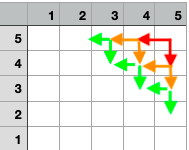

To improve performance *graft* starts from the infinity record as well as every record from the training dataset because they're highly likely to provide us with many distinct leaves.

In [15]:
%%time
def graft(rf, df, verbose=False):
  if verbose: print (datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
  tree_list = list_trees(rf, df)
  score_df = copy.deepcopy(df[0:1])
  score_df[:] = np.float(2**31-1)
  score_df = score_df.append(df)
  score_df_all = copy.deepcopy(score_df)
  leaves = score_leaves(rf, score_df)
  leaves_out = leaves.copy()
  if verbose: print (datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") + ' - ' + str(leaves_out.shape[0]) + ' - ' + str(score_df.shape[0]))
  grafted_leaves = graft_leaves(tree_list, leaves)
  grafted_df = grafted_leaves.copy()
  while(True):
    [score_df, score_df_all] = update_score_df(score_df_all, grafted_leaves)
    leaves = score_leaves(rf, score_df)
    leaves = leaves.drop_duplicates()

    len_before = leaves_out.shape[0]
    leaves_out = leaves_out.append(leaves)
    leaves_out = leaves_out.drop_duplicates()
    if verbose: print (datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") + ' - ' + str(leaves_out.shape[0]) + ' - ' + str(score_df.shape[0]))
    grafted_leaves = graft_leaves(tree_list, leaves)
    grafted_df = grafted_df.append(grafted_leaves)
    if(len_before == leaves_out.shape[0]):
      break
  grafted_df = grafted_df.drop_duplicates()
  return(grafted_df)
  
grafted_df = graft(rf, df.drop(['Trading Interval', 'Metered Generation (Total; MWh)'], axis=1), verbose=True)

2020-11-17 00:18:58
2020-11-17 00:19:01 - 172321 - 172321
2020-11-17 00:19:07 - 9766 - 58895
2020-11-17 00:19:08 - 13992 - 60353
2020-11-17 00:19:10 - 16313 - 49255
2020-11-17 00:19:11 - 17111 - 27176
2020-11-17 00:19:12 - 17279 - 9384
2020-11-17 00:19:13 - 17314 - 1976
2020-11-17 00:19:14 - 17320 - 417
2020-11-17 00:19:15 - 17322 - 70
2020-11-17 00:19:16 - 17322 - 21
CPU times: user 17.7 s, sys: 731 ms, total: 18.4 s
Wall time: 18.3 s


Let's have a look at the output. The two 985 leaf trees have a total of 17,322 overlapping combinations.

In [16]:
grafted_df

,,<hour,hour<=,<weekday,weekday<=,<month,month<=,<year,year<=,<Maximum temperature (Degree C),Maximum temperature (Degree C)<=,<Minimum temperature (Degree C),Minimum temperature (Degree C)<=,<max_lag1,max_lag1<=,<min_lag1,min_lag1<=,<max_lag2,max_lag2<=,<min_lag2,min_lag2<=,<max_lead1,max_lead1<=,<min_lead1,min_lead1<=,<Daily global solar exposure (MJ/m*m),Daily global solar exposure (MJ/m*m)<=,value
leaf0,leaf1,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-1968,1-1948,23.25,inf,-inf,inf,-inf,inf,2011.5,inf,43.349998,inf,18.849998,inf,33.649998,inf,-inf,inf,-inf,inf,-inf,inf,-inf,inf,21.949999,inf,-inf,inf,1280.823161
0-968,1-967,6.75,9.75,-inf,4.5,-inf,8.5,-inf,2016.5,19.449999,33.25,-inf,17.150000,-inf,28.549999,-inf,inf,-inf,inf,-inf,inf,-inf,inf,-inf,inf,13.05,inf,1087.484881
0-969,1-967,9.75,15.75,-inf,4.5,-inf,8.5,-inf,2016.5,19.449999,33.25,-inf,17.150000,-inf,28.549999,-inf,inf,-inf,inf,-inf,inf,-inf,inf,-inf,inf,13.05,inf,1057.698254
0-1058,1-1052,15.75,20.75,-inf,4.5,-inf,3.5,-inf,inf,30.949999,33.25,-inf,17.049999,-inf,inf,-inf,inf,-inf,inf,-inf,inf,-inf,inf,-inf,inf,-inf,inf,1260.152521
0-1080,1-1064,20.75,21.75,-inf,4.5,-inf,inf,-inf,inf,31.150000,33.25,-inf,17.150000,20.349998,inf,-inf,inf,19.75,inf,-inf,inf,-inf,inf,-inf,17.549999,-inf,inf,1087.211469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0-1304,1-1206,14.75,15.75,4.5,inf,-inf,inf,2016.5,inf,-inf,13.80,18.150000,18.250000,28.049999,31.500000,-inf,inf,-inf,19.25,-inf,13.9,-inf,inf,-inf,inf,-inf,6.3,1036.887429
0-1328,1-1207,10.75,15.75,4.5,inf,-inf,inf,-inf,inf,13.800000,20.15,18.150000,18.250000,31.500000,inf,-inf,inf,-inf,19.25,-inf,inf,-inf,inf,17.600000,inf,-inf,6.3,1117.272229
0-1326,1-1207,10.75,15.75,4.5,inf,-inf,inf,-inf,inf,13.800000,20.15,18.150000,18.250000,31.500000,inf,-inf,inf,-inf,19.25,-inf,inf,-inf,inf,16.299999,17.600000,-inf,6.3,1096.132738


Let's pick one validation record to test with.

In [17]:
val_features['orig_prediction'] = rf.predict(val_features.drop('Trading Interval', axis=1))
val_feature = val_features[0:1]
val_feature

,Trading Interval,hour,weekday,month,year,Maximum temperature (Degree C),Minimum temperature (Degree C),max_lag1,min_lag1,max_lag2,min_lag2,max_lead1,min_lead1,Daily global solar exposure (MJ/m*m),orig_prediction
154800,2019-01-01 08:00:00,8.0,1,1,2019,34.1,16.3,32.2,13.9,29.7,11.7,24.6,20.0,31.4,784.62116


And define a function to find which grafted rule matches to a given input.

In [18]:
%%time
def match_grafted(feature, grafted_df):
  lt_cols = grafted_df.columns[:-1:2]
  gt_cols = grafted_df.columns[1::2]
  col = lt_cols[0][1:]
  matches = [True] * len(grafted_df)
  for i in range(len(lt_cols)):
    col = lt_cols[i][1:]
    matches = matches & (grafted_df[lt_cols[i]] < feature[col].values[0]) & (feature[col].values[0] <= grafted_df[gt_cols[i]])
  return(grafted_df[matches])

matched = match_grafted(val_feature, grafted_df)

CPU times: user 20.5 ms, sys: 61 µs, total: 20.5 ms
Wall time: 21 ms


Now we can compare that both the original prediction above and the grafted output value both equal 784.62116.

In [19]:
matched

,,<hour,hour<=,<weekday,weekday<=,<month,month<=,<year,year<=,<Maximum temperature (Degree C),Maximum temperature (Degree C)<=,<Minimum temperature (Degree C),Minimum temperature (Degree C)<=,<max_lag1,max_lag1<=,<min_lag1,min_lag1<=,<max_lag2,max_lag2<=,<min_lag2,min_lag2<=,<max_lead1,max_lead1<=,<min_lead1,min_lead1<=,<Daily global solar exposure (MJ/m*m),Daily global solar exposure (MJ/m*m)<=,value
leaf0,leaf1,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-1504,1-1500,6.75,10.75,0.5,4.5,-inf,3.5,2017.5,inf,34.049999,inf,-inf,16.75,31.0,33.649998,-inf,inf,29.1,inf,-inf,17.349998,-inf,inf,18.0,inf,-inf,inf,784.62116


Now let's test the results of all the validation records.

In [20]:
%%time
val_features['grafted_prediction'] = 0.1
for i in range(val_features.shape[0]):
  val_feature = val_features[i:i+1]
  value = match_grafted(val_feature, grafted_df)['value']
  if value.shape[0] > 0:
    val_features.loc[val_feature.index[0],'grafted_prediction'] = np.float64(value)

CPU times: user 4min 48s, sys: 15.7 s, total: 5min 3s
Wall time: 5min 5s


100% match, Grafting created a perfect meta-model of Random Forest.

In [21]:
np.mean(val_features['grafted_prediction'] == val_features['orig_prediction'])

1.0


In [22]:
val_features[val_features['grafted_prediction'] != val_features['orig_prediction']]

,Trading Interval,hour,weekday,month,year,Maximum temperature (Degree C),Minimum temperature (Degree C),max_lag1,min_lag1,max_lag2,min_lag2,max_lead1,min_lead1,Daily global solar exposure (MJ/m*m),orig_prediction,grafted_prediction


# Reassemble

**Reassemble** takes the **Graft** output and converts it into an efficient decision tree. This runs faster than the original Random Forest because there are fewer operations to perform.

The *match* function that we defined earlier works, but very slowly.

First step is to take a dataset of graft rules and find the column and value that does the best job of evenly splitting the rules. 

The nature of the rules makes it impossible in many cases to efficiently split without some rules being on both sides, so the algorithm minimises a calculation that considers both the difference in row count between the two sides of the split (eveness) and the sum of row counts on both sides (rules that aren't split).

In [16]:
%%time
def split_graft(grafted_df):
  all_len = grafted_df.shape[0]
  lt_cols = grafted_df.columns[:-1:2]
  gt_cols = grafted_df.columns[1::2]
  most_even_split_diff = 999999999999999
  most_even_split_value = 0
  most_even_split_col = -1
  for i in range(len(lt_cols)):
    lt_col = lt_cols[i]
    gt_col = gt_cols[i]
    grafted_df = grafted_df.sort_values(gt_col)
    split_value = grafted_df[gt_col].values[int(grafted_df.shape[0] / 2)]
    split_value_inc = np.nextafter(split_value.astype('float32'), 1)
    lt_len = sum(grafted_df[lt_col] < split_value_inc)
    gt_len = sum(grafted_df[gt_col] > split_value_inc)
    while((lt_len == all_len)&(sum(grafted_df[gt_col].values < split_value) > 0)):
      split_value = max(grafted_df[gt_col].values[grafted_df[gt_col].values < split_value])
      split_value_inc = np.nextafter(split_value.astype('float32'), 1)
      lt_len = sum(grafted_df[lt_col] < split_value_inc)
      gt_len = sum(grafted_df[gt_col] > split_value_inc)
    while((gt_len == all_len)&(sum(grafted_df[gt_col].values > split_value) > 0)):
      split_value = min(grafted_df[gt_col].values[grafted_df[gt_col].values > split_value])
      split_value_inc = np.nextafter(split_value.astype('float32'), 1)
      lt_len = sum(grafted_df[lt_col] < split_value_inc)
      gt_len = sum(grafted_df[gt_col] > split_value_inc)
    split_diff = (abs(lt_len - gt_len)+2)**2 + ((lt_len + gt_len)**2)
    if (split_diff < most_even_split_diff) & (lt_len > 0) & (gt_len > 0) & (lt_len < all_len) & (gt_len < all_len):
      most_even_split_diff = split_diff
      most_even_split_value = split_value
      most_even_split_col = i
  return [gt_cols[most_even_split_col], lt_cols[most_even_split_col], most_even_split_value]

[most_even_split_gt_col, most_even_split_lt_col, most_even_split_value] = split_graft(grafted_df)

CPU times: user 1.47 s, sys: 2.64 ms, total: 1.47 s
Wall time: 1.47 s


Let's check where the split is for the full graft dataset.

In [17]:
[most_even_split_gt_col, most_even_split_lt_col, most_even_split_value]

['hour<=', '<hour', 7.75]

Next we recurse through the splits until we end up with a single record, at which point we return the output value.

In [18]:
%%time
def dataframe_to_tree_recurse(grafted_df, node = 0):
  if grafted_df.shape[0] == 1:
    return([[_tree.TREE_LEAF], [_tree.TREE_LEAF], [_tree.TREE_UNDEFINED], [_tree.TREE_UNDEFINED], [grafted_df['value'].iloc[0]]])

  [most_even_split_gt_col, most_even_split_lt_col, most_even_split_value] = split_graft(grafted_df)

  grafted_df_lt = grafted_df[grafted_df[most_even_split_lt_col] < most_even_split_value]
  grafted_df_gt = grafted_df[grafted_df[most_even_split_gt_col] > most_even_split_value]
  left = dataframe_to_tree_recurse(grafted_df_lt, node+1)
  right = dataframe_to_tree_recurse(grafted_df_gt, node + len(left[0]) + 1)

  children_left = [node + 1] + left[0] + right[0]
  children_right = [node + len(left[0]) + 1] + left[1] + right[1]
  feature = [most_even_split_gt_col] + left[2] + right[2]
  threshold = [most_even_split_value] + left[3] + right[3]
  value = [0] + left[4] + right[4]

  return([children_left, children_right, feature, threshold, value])

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.3 µs


Finally we contruct a decision tree to hold the reassembled graft and overwrite the new structure in.

In [19]:
%%time
def reassemble(grafted_df):
  [children_left, children_right, feature, threshold, value] = dataframe_to_tree_recurse(grafted_df)
  grafted_X = grafted_df[grafted_df.columns[1::2]].copy().rename(columns = lambda x : str(x)[:-2])
  grafted_X = grafted_X.append(grafted_X).append(grafted_X)
  grafted_Y = grafted_df['value']
  grafted_Y = grafted_Y.append(grafted_Y).append(grafted_Y)
  grafted_X[:] = np.expand_dims(range(len(grafted_X)), 1)
  grafted_Y[:] = range(len(grafted_Y))

  grafted_dt = DecisionTreeRegressor()
  grafted_dt = grafted_dt.fit(grafted_X, grafted_Y)
  grafted_dt.tree_.children_left[0:len(children_left)] = children_left
  grafted_dt.tree_.children_right[0:len(children_right)] = children_right
  grafted_dt.tree_.threshold[0:len(threshold)] = np.nextafter(threshold, 1)
  grafted_dt.tree_.value[0:len(value)] = np.expand_dims(np.expand_dims(value, 1), 1)
  
  threshold = np.float32(threshold)
  for i in range(len(threshold)):
    threshold[i] = threshold[i] + abs(threshold[i] - np.nextafter(threshold[i], 1))*10
  grafted_dt.tree_.threshold[0:len(threshold)] = threshold

  cols = grafted_df.columns[1::2].tolist()
  feature_indexes = [cols.index(x) if x != -2 else -2 for x in feature]
  grafted_dt.tree_.feature[0:len(feature_indexes)] = feature_indexes

  return(grafted_dt)

grafted_dt = reassemble(grafted_df)

CPU times: user 7min 32s, sys: 404 ms, total: 7min 32s
Wall time: 7min 32s


Now let's check it for speed, let's try 10,000 iterations to get a consistent answer.

42.1 seconds.

In [21]:
%%time
for i in range(10000):
  grafted_dt_preds = grafted_dt.predict(val_features.drop(['Trading Interval', 'orig_prediction', 'grafted_prediction'], axis=1))

CPU times: user 41.5 s, sys: 484 ms, total: 42 s
Wall time: 42.1 s


Running the Random Forest 10,000 times takes 47.4 seconds.

This time the performance improvement was 12.5%, but has been observed as high as 20%.

In [22]:
%%time
for i in range(10000):
  rf_preds = rf.predict(val_features.drop(['Trading Interval', 'orig_prediction', 'grafted_prediction'], axis=1))

CPU times: user 46.8 s, sys: 555 ms, total: 47.3 s
Wall time: 47.4 s


Also we'll make sure that the results are consistent.

In [23]:
np.mean(grafted_dt_preds == rf_preds)

1.0

In [24]:
grafted_dt_preds = grafted_dt.predict(val_features.drop(['Trading Interval', 'orig_prediction', 'grafted_prediction'], axis=1))
val_features['grafted_dt_prediction'] = grafted_dt_preds
val_features[grafted_dt_preds != rf_preds]

,Trading Interval,hour,weekday,month,year,Maximum temperature (Degree C),Minimum temperature (Degree C),max_lag1,min_lag1,max_lag2,min_lag2,max_lead1,min_lead1,Daily global solar exposure (MJ/m*m),grafted_dt_prediction


Reassemble also allows for more sophisticated pruning of the model. In this casce we know that we'll never encounter historic records (because the model is intended to predict the future only), so we can reassemble purely on the rules that have a "year<=" value of infinity (if they end they're in the past and so therefore are unreachable).

In [26]:
%%time
grafted_dt = reassemble(grafted_df[grafted_df['year<='] == np.float('inf')])

CPU times: user 4min 29s, sys: 241 ms, total: 4min 30s
Wall time: 4min 29s


This new model is even faster - 38.7 seconds for 10,000 iterations, 22.5% faster than the original model.

In [28]:
%%time
for i in range(10000):
  grafted_dt_preds = grafted_dt.predict(val_features.drop(['Trading Interval', 'orig_prediction', 'grafted_prediction', 'grafted_dt_prediction'], axis=1))

CPU times: user 38.3 s, sys: 408 ms, total: 38.7 s
Wall time: 38.7 s


And we can confirm that it still perfectly replicates the Random Forest results.

In [33]:
np.mean(grafted_dt_preds == rf_preds)

1.0

# Amalgamate

**Amalgamate** simplifies the **Graft** output by merging records whose difference in prediction is below a given threshold and form a contiguous box (i.e. a hyperrectangle), which maintains the integrity of the decision tree struture.

First step is to sort the graft by value and compare nearby records, which implies that they are a candidate for merging. We're also going to define some columns that we'll use later.

Then we define *find_matches*, which searches for records that match on all <x and x<= columns, except two. This implies that they potentially form a contiguous box,

In [34]:
%%time
def initialise_shift(amalgamated_df, shifts):
  amalgamated_df = amalgamated_df.sort_values('value')
  amalgamated_df['lead_diff'] = amalgamated_df['value'].shift(-shifts) - amalgamated_df['value']
  amalgamated_df['lag_diff'] = amalgamated_df['value'] - amalgamated_df['value'].shift(shifts)
  amalgamated_df['min_diff'] = amalgamated_df[['lead_diff', 'lag_diff']].min(axis=1)
  amalgamated_df_shift = amalgamated_df.shift(shifts)
  return [amalgamated_df, amalgamated_df_shift]

def find_matches(amalgamated_df, amalgamated_df_shift, shifts):
  drops = ['value', 'lead_diff', 'lag_diff', 'min_diff', 'amalgamate_count', 'amalgamate_total', 'amalgamate_min', 'amalgamate_max']
  match_columns = len(amalgamated_df.drop(drops, axis=1).columns) - 2
  matches = np.sum(amalgamated_df.drop(drops, axis=1) == amalgamated_df_shift.drop(drops, axis=1), axis=1) == match_columns
  return(matches)

shifts = 3

amalgamated_df = grafted_df.copy()

amalgamated_df['amalgamate_count'] = 1
amalgamated_df['amalgamate_total'] = amalgamated_df['value']
amalgamated_df['amalgamate_min'] = amalgamated_df['value']
amalgamated_df['amalgamate_max'] = amalgamated_df['value']

[amalgamated_df, amalgamated_df_shift] = initialise_shift(amalgamated_df, shifts)
matches = find_matches(amalgamated_df, amalgamated_df_shift, shifts)

CPU times: user 25.2 ms, sys: 0 ns, total: 25.2 ms
Wall time: 24.7 ms


Let's have a look at the output, we can see that we've found at least one potential match.

In [35]:
matches

leaf0   leaf1 
0-80    1-28      False
0-266   1-120     False
0-74    1-120     False
0-80    1-41      False
0-74    1-28      False
                  ...  
0-1769  1-1573    False
0-1889  1-1574    False
0-1887  1-1574     True
0-1883  1-1804    False
0-1890  1-1804    False
Length: 17322, dtype: bool

Next we define *find_close_shift_matched_box*, which determines whether any of the candidates form a contiguous box that is below the defined threshold.

The amalgamate min and max values are the maximum and minimum predictions of all grafts that made up the record. These values are tested to make sure we don't accidentally end up with run-away merging that combines grafts that are individually too far apart.

In [36]:
%%time
def find_close_shift_matched_box(amalgamated_df, amalgamated_df_shift, shifts, matches, row, threshold):
  grafted_row = amalgamated_df[matches][row:row+1]
  grafted_row_shift = amalgamated_df_shift[matches][row:row+1]
  for c_lt in grafted_row.columns[:-8:2]:   #-8:2 because we only need to consider the <x & x<= pairs
    c_gt = c_lt[1:]+'<='
    if (grafted_row[c_lt][0] == grafted_row_shift[c_gt][0]) | (grafted_row[c_gt][0] == grafted_row_shift[c_lt][0]):
      if ((abs(grafted_row['amalgamate_min'][0] - grafted_row_shift['amalgamate_max'][0]) < threshold) &
          (abs(grafted_row['amalgamate_max'][0] - grafted_row_shift['amalgamate_min'][0]) < threshold)):
        return([c_lt, c_gt])
  return([None, None])                      #return None if we don't find any usable matches

threshold = 1
row = 0
[c_lt, c_gt] = find_close_shift_matched_box(amalgamated_df, amalgamated_df_shift, shifts, matches, 0, threshold)

CPU times: user 2.43 ms, sys: 6 µs, total: 2.43 ms
Wall time: 2.14 ms


Let's have a look at the match details

In [37]:
[c_lt, c_gt]

['<hour', 'hour<=']

And the grafts we've decided to merge

In [38]:
amalgamated_df[matches][row:row+1].append(amalgamated_df_shift[matches][row:row+1])

<hour  hour<=  <weekday  ...  lead_diff  lag_diff  min_diff
leaf0 leaf1                           ...                               
0-875 1-940   6.25    6.75       4.5  ...   0.162813  0.107558  0.107558
      1-940   5.75    6.25       4.5  ...   0.107558  0.027879  0.027879

[2 rows x 34 columns]

Note that the indexes of both rows are the same because that's how shift works, but we need the indexes of both to complete the combine. Let's find the raw shifted record.

In [39]:
amalgamated_df[:-shifts][matches[shifts:].to_list()][row:row+1]

,,<hour,hour<=,<weekday,weekday<=,<month,month<=,<year,year<=,<Maximum temperature (Degree C),Maximum temperature (Degree C)<=,<Minimum temperature (Degree C),Minimum temperature (Degree C)<=,<max_lag1,max_lag1<=,<min_lag1,min_lag1<=,<max_lag2,max_lag2<=,<min_lag2,min_lag2<=,<max_lead1,max_lead1<=,<min_lead1,min_lead1<=,<Daily global solar exposure (MJ/m*m),Daily global solar exposure (MJ/m*m)<=,value,amalgamate_count,amalgamate_total,amalgamate_min,amalgamate_max,lead_diff,lag_diff,min_diff
leaf0,leaf1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-874,1-939,5.75,6.25,4.5,inf,-inf,9.5,2013.5,inf,-inf,inf,24.549999,inf,-inf,19.699999,-inf,19.85,20.449999,20.65,-inf,inf,-inf,inf,-inf,10.75,-inf,inf,984.805455,1,984.805455,984.805455,984.805455,0.107558,0.027879,0.027879


Note that the graft had 17,322 rows.

In [40]:
amalgamated_df.shape

(17322, 34)

Now let's define *combine* to merge the identified grafts.

The min <x value and max x<= values are taken to define the new graft. A running total of the graft values is maintained so that additional records can be merged consistently if they satisfy the requirements.

All graft records are considered equal when being combined. This is similar to how a Random Forest averages the leaves of each tree without consideration of the number of records used to calculate each leaf. Arguably the leaves of each tree could be recalculated, but it is unlikely to make a significant difference to the result because only close results are merged.

The index isn't updated, but the functions that rely on it won't work now that the graft no longer matches the Random Forest.

In [41]:
%%time
def combine_grafts(amalgamated_df, amalgamated_df_shift, shifts, matches, row, c_lt, c_gt):
  grafted_row = amalgamated_df[matches][row:row+1]
  grafted_row_shift = amalgamated_df_shift[matches][row:row+1]
  amalgamated_df.at[grafted_row.index, c_lt]=np.min(grafted_row[c_lt][0:1].append(grafted_row_shift[c_lt][0:1]))
  amalgamated_df.at[grafted_row.index, c_gt]=np.max(grafted_row[c_gt][0:1].append(grafted_row_shift[c_gt][0:1]))
  amalgamated_df = amalgamated_df.drop(amalgamated_df[:-shifts][matches[shifts:].to_list()][row:row+1].index)

  count = np.sum(grafted_row['amalgamate_count'][0:1].append(grafted_row_shift['amalgamate_count'][0:1]))
  total = np.sum(grafted_row['amalgamate_total'][0:1].append(grafted_row_shift['amalgamate_total'][0:1]))
  min = np.min(grafted_row['amalgamate_min'][0:1].append(grafted_row_shift['amalgamate_min'][0:1]))
  max = np.max(grafted_row['amalgamate_max'][0:1].append(grafted_row_shift['amalgamate_max'][0:1]))

  amalgamated_df.at[grafted_row.index, 'amalgamate_count'] = count
  amalgamated_df.at[grafted_row.index, 'amalgamate_total'] = total
  amalgamated_df.at[grafted_row.index, 'value'] = total / count
  amalgamated_df.at[grafted_row.index, 'amalgamate_min'] = min
  amalgamated_df.at[grafted_row.index, 'amalgamate_max'] = max

  return(amalgamated_df)

amalgamated_df = combine_grafts(amalgamated_df, amalgamated_df_shift, shifts, matches, row, c_lt, c_gt)

CPU times: user 125 ms, sys: 0 ns, total: 125 ms
Wall time: 125 ms


Let's have a look at the combined graft.

In [42]:
amalgamated_df.loc[[('0-875','1-940')]]

,,<hour,hour<=,<weekday,weekday<=,<month,month<=,<year,year<=,<Maximum temperature (Degree C),Maximum temperature (Degree C)<=,<Minimum temperature (Degree C),Minimum temperature (Degree C)<=,<max_lag1,max_lag1<=,<min_lag1,min_lag1<=,<max_lag2,max_lag2<=,<min_lag2,min_lag2<=,<max_lead1,max_lead1<=,<min_lead1,min_lead1<=,<Daily global solar exposure (MJ/m*m),Daily global solar exposure (MJ/m*m)<=,value,amalgamate_count,amalgamate_total,amalgamate_min,amalgamate_max,lead_diff,lag_diff,min_diff
leaf0,leaf1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-875,1-940,5.75,6.75,4.5,inf,-inf,9.5,2013.5,inf,-inf,inf,24.549999,inf,-inf,19.699999,-inf,19.85,20.449999,20.65,-inf,inf,-inf,inf,-inf,10.75,-inf,inf,984.859234,2.0,1969.718468,984.805455,984.913013,0.162813,0.107558,0.107558


Note that the graft dataframe is now one record shorter.

In [43]:
amalgamated_df.shape

(17321, 34)

And check to see if there are other grafts that can be merged.

In [44]:
shifts = 5
row = 0

amalgamated_df = amalgamated_df.sort_values('value')
amalgamated_df['lead_diff'] = amalgamated_df['value'].shift(-shifts) - amalgamated_df['value']
amalgamated_df['lag_diff'] = amalgamated_df['value'] - amalgamated_df['value'].shift(shifts)
amalgamated_df['min_diff'] = amalgamated_df[['lead_diff', 'lag_diff']].min(axis=1)
amalgamated_df_shift = amalgamated_df.shift(shifts)
matches = find_matches(amalgamated_df, amalgamated_df_shift, shifts)
[c_lt, c_gt] = find_close_shift_matched_box(amalgamated_df, amalgamated_df_shift, shifts, matches, row, threshold)
[c_lt, c_gt]

['<max_lag2', 'max_lag2<=']

Let's put it all together. *Amalgamate* iterates through increasingly large shifts until none of the value differences are less than the threshold.

In [45]:
%%time
def amalgamate(grafted_df, threshold):
  amalgamated_df = grafted_df.copy()
  min_min_diff = threshold
  shifts = 0
  rows_combined = 1
  amalgamated_df['amalgamate_count'] = 1
  amalgamated_df['amalgamate_total'] = amalgamated_df['value']
  amalgamated_df['amalgamate_min'] = amalgamated_df['value']
  amalgamated_df['amalgamate_max'] = amalgamated_df['value']
  while rows_combined > 0:
    rows_combined = 0
    while min_min_diff <= threshold:
      shifts += 1
      [amalgamated_df, amalgamated_df_shift] = initialise_shift(amalgamated_df, shifts)
      min_min_diff = np.min(amalgamated_df['min_diff'])
      matches = find_matches(amalgamated_df, amalgamated_df_shift, shifts)
      match_count = np.sum(matches)
      row = 0
      while row < match_count:
        [c_lt, c_gt] = find_close_shift_matched_box(amalgamated_df, amalgamated_df_shift, shifts, matches, row, threshold)
        if c_lt is not None:
          amalgamated_df = combine_grafts(amalgamated_df, amalgamated_df_shift, shifts, matches, row, c_lt, c_gt)
          [amalgamated_df, amalgamated_df_shift] = initialise_shift(amalgamated_df, shifts)
          matches = find_matches(amalgamated_df, amalgamated_df_shift, shifts)
          match_count = np.sum(matches)
          rows_combined += 1
        else:
          row += 1
  return amalgamated_df

amalgamated_df = amalgamate(grafted_df, threshold)

CPU times: user 4.02 s, sys: 59.1 ms, total: 4.08 s
Wall time: 4.12 s


So combining all grafts less than 1 MWh (about 0.1% of the average) removes a bit over 0.1% of the complexity.

In [46]:
amalgamated_df.shape

(17291, 34)

Let's have a look at the records that were combined.

In [47]:
amalgamated_df[amalgamated_df['amalgamate_count'] > 1]

,,<hour,hour<=,<weekday,weekday<=,<month,month<=,<year,year<=,<Maximum temperature (Degree C),Maximum temperature (Degree C)<=,<Minimum temperature (Degree C),Minimum temperature (Degree C)<=,<max_lag1,max_lag1<=,<min_lag1,min_lag1<=,<max_lag2,max_lag2<=,<min_lag2,min_lag2<=,<max_lead1,max_lead1<=,<min_lead1,min_lead1<=,<Daily global solar exposure (MJ/m*m),Daily global solar exposure (MJ/m*m)<=,value,amalgamate_count,amalgamate_total,amalgamate_min,amalgamate_max,lead_diff,lag_diff,min_diff
leaf0,leaf1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-875,1-940,5.75,6.75,4.5,inf,-inf,9.5,2013.5,inf,-inf,inf,24.549999,inf,-inf,19.699999,-inf,19.850000,20.449999,20.65,-inf,inf,-inf,inf,-inf,10.75,-inf,inf,984.859234,2.0,1969.718468,984.805455,984.913013,2.094847,1.448624,1.448624
0-672,1-748,5.75,6.75,-inf,4.5,9.5,inf,-inf,2011.5,-inf,inf,16.650000,19.349998,41.599998,inf,-inf,inf,34.099998,inf,-inf,inf,-inf,inf,-inf,inf,-inf,32.799999,996.150940,2.0,1992.301881,996.024483,996.277398,1.498786,2.086084,1.498786
0-344,1-401,-inf,0.75,-inf,inf,2.5,inf,-inf,2011.5,-inf,inf,22.849998,inf,34.049999,37.049999,21.650000,inf,32.549999,inf,-inf,18.850000,-inf,inf,-inf,inf,-inf,inf,998.677214,2.0,1997.354429,998.264172,999.090257,1.590226,1.613009,1.590226
0-623,1-590,6.25,6.75,-inf,4.5,9.5,inf,2013.5,2016.5,-inf,20.299999,-inf,5.800000,-inf,20.349998,-inf,inf,19.250000,inf,-inf,inf,21.85,inf,-inf,inf,23.25,inf,999.287987,2.0,1998.575974,999.117899,999.458075,1.690600,1.684577,1.684577
0-624,1-590,6.25,6.75,-inf,4.5,9.5,inf,2013.5,2016.5,20.299999,20.549999,-inf,5.800000,-inf,20.349998,-inf,inf,19.250000,inf,-inf,inf,21.85,inf,-inf,inf,23.25,inf,1012.274224,2.0,2024.548448,1012.104136,1012.444312,2.298166,1.716464,1.716464
0-344,1-57,-inf,0.75,-inf,inf,-inf,inf,-inf,2012.5,-inf,inf,22.849998,inf,33.649998,34.049999,21.650000,24.349998,33.750000,inf,-inf,inf,-inf,inf,-inf,inf,-inf,inf,1015.239488,2.0,2030.478976,1014.826446,1015.652530,2.197657,2.386713,2.197657
0-631,1-590,6.25,6.75,-inf,4.5,9.5,inf,2016.5,inf,-inf,20.549999,-inf,5.800000,-inf,20.349998,-inf,inf,19.250000,inf,12.250000,inf,21.85,inf,-inf,inf,-inf,inf,1016.089012,2.0,2032.178024,1015.918924,1016.259100,1.881525,2.403610,1.881525
0-589,1-590,6.25,6.75,-inf,4.5,-inf,9.5,2013.5,inf,-inf,20.549999,-inf,5.800000,16.750000,20.349998,-inf,inf,-inf,inf,16.199999,inf,21.85,inf,-inf,inf,-inf,inf,1034.860442,2.0,2069.720884,1034.690354,1035.030530,2.569106,2.126135,2.126135
0-621,1-590,6.25,6.75,-inf,4.5,9.5,inf,2013.5,2016.5,-inf,20.549999,-inf,5.800000,-inf,20.349998,-inf,inf,19.250000,inf,-inf,inf,21.85,inf,-inf,inf,-inf,23.250000,1035.071573,2.0,2070.143147,1034.901486,1035.241661,2.601148,2.152561,2.152561


And have a look at the predictions that have changed.

In [48]:
%%time
val_features['amalgamated_prediction'] = 0.1
for i in range(val_features.shape[0]):
  val_feature = val_features[i:i+1]
  value = match_grafted(val_feature, amalgamated_df.drop(['amalgamate_count','amalgamate_total','amalgamate_max','amalgamate_min','lead_diff','lag_diff','min_diff'], axis=1))['value']
  if value.shape[0] > 0:
    val_features.loc[val_feature.index[0],'amalgamated_prediction'] = np.float64(value)

CPU times: user 5min 25s, sys: 16.4 s, total: 5min 41s
Wall time: 5min 44s


In [49]:
val_features[val_features['grafted_prediction'] != val_features['amalgamated_prediction']]

,Trading Interval,hour,weekday,month,year,Maximum temperature (Degree C),Minimum temperature (Degree C),max_lag1,min_lag1,max_lag2,min_lag2,max_lead1,min_lead1,Daily global solar exposure (MJ/m*m),orig_prediction,grafted_prediction,grafted_dt_prediction,amalgamated_prediction
160605,2019-05-02 06:30:00,6.5,3,5,2019,19.9,4.8,18.3,5.9,21.3,3.7,27.5,9.0,15.0,1106.169725,1106.169725,1106.169725,1106.339813
162957,2019-06-20 06:30:00,6.5,3,6,2019,19.6,5.1,19.1,2.7,17.9,2.4,24.0,10.3,10.7,1106.509901,1106.509901,1106.509901,1106.339813
165837,2019-08-19 06:30:00,6.5,0,8,2019,19.7,2.5,18.6,1.9,15.9,5.7,23.2,4.3,16.4,1106.509901,1106.509901,1106.509901,1106.339813
166701,2019-09-06 06:30:00,6.5,4,9,2019,20.4,3.0,16.7,2.6,16.8,10.3,22.0,1.7,19.2,1159.855856,1159.855856,1159.855856,1159.685768


Let's have a look how much is combined if we set the threshold to 10 MWh (about 1% of the average).

In [50]:
%%time
print(grafted_df.shape)
amalgamated_df = amalgamate(grafted_df, 10)
print(amalgamated_df.shape)

(17322, 27)
(16448, 34)
CPU times: user 1min 14s, sys: 568 ms, total: 1min 15s
Wall time: 1min 14s


So that's a reduction in complexity of a bit over 5%. 

It's possible to push the complexity as far down as a user desires, with the obvious compromise in accuracy.

In [51]:
%%time
amalgamated_df = amalgamate(grafted_df, 100)
print(amalgamated_df.shape)

(8201, 34)
CPU times: user 9min 44s, sys: 3.41 s, total: 9min 48s
Wall time: 9min 48s


But there is a price to be paid in accuracy, in this case halving the size of the model increased validation error by about 5%.

In [53]:
%%time
val_features['amalgamated_prediction'] = 0.1
for i in range(val_features.shape[0]):
  val_feature = val_features[i:i+1]
  value = match_grafted(val_feature, amalgamated_df.drop(['amalgamate_count','amalgamate_total','amalgamate_max','amalgamate_min','lead_diff','lag_diff','min_diff'], axis=1))['value']
  if value.shape[0] > 0:
    val_features.loc[val_feature.index[0],'amalgamated_prediction'] = np.float64(value)
    
print(np.mean(abs(val_labels - val_features['orig_prediction'])))
print(np.mean(abs(val_labels - val_features['amalgamated_prediction'])))

71.78541896281322
75.71111111202389
CPU times: user 3min 26s, sys: 318 ms, total: 3min 27s
Wall time: 3min 27s


If we push amalgamate even further then we start to hit a plateau in the number of rules being removed.

In [54]:
%%time
amalgamated_df = amalgamate(grafted_df, 200)
print(amalgamated_df.shape)

(7519, 34)
CPU times: user 10min 28s, sys: 3.98 s, total: 10min 32s
Wall time: 10min 32s


But this curiously improves validation error slightly.

In [55]:
%%time
val_features['amalgamated_prediction'] = 0.1
for i in range(val_features.shape[0]):
  val_feature = val_features[i:i+1]
  value = match_grafted(val_feature, amalgamated_df.drop(['amalgamate_count','amalgamate_total','amalgamate_max','amalgamate_min','lead_diff','lag_diff','min_diff'], axis=1))['value']
  if value.shape[0] > 0:
    val_features.loc[val_feature.index[0],'amalgamated_prediction'] = np.float64(value)

print(np.mean(abs(val_labels - val_features['orig_prediction'])))
print(np.mean(abs(val_labels - val_features['amalgamated_prediction'])))

71.78541896281322
75.60925540331219
CPU times: user 3min 25s, sys: 408 ms, total: 3min 25s
Wall time: 3min 25s


# Neighbour sensitivity

**Neighbour sensitivity** finds all neighbours on the edge of any given prediction and the minimum change in explanatory data required for a different result. Helpful to find discontinuities in the model, and to explain what changes need to occur to achieve a different prediction.

First let's pick a validation record.

In [29]:
val_feature = val_features[10:11]
val_feature

,Trading Interval,hour,weekday,month,year,Maximum temperature (Degree C),Minimum temperature (Degree C),max_lag1,min_lag1,max_lag2,min_lag2,max_lead1,min_lead1,Daily global solar exposure (MJ/m*m),grafted_dt_prediction
154810,2019-01-01 13:00:00,13.0,1,1,2019,34.1,16.3,32.2,13.9,29.7,11.7,24.6,20.0,31.4,1338.205357


If we check the actual result we can see that the model predicted a bit high, a bit over 400 MWh too high.

In [30]:
val_labels[10:11]

154810    930.899
Name: Metered Generation (Total; MWh), dtype: float64

Next let's find all of the neighbouring records.

*find_neighbours* iterates through each column and maintains a running list of all records in the Graft output that border or overlap.

In [33]:
%%time
def find_neighbours(val_feature, grafted_df):
  val_grafted = match_grafted(val_feature, grafted_df)

  lt_cols = grafted_df.columns[:-1:2]
  gt_cols = grafted_df.columns[1::2]
  col = lt_cols[0]
  matches = (grafted_df[lt_cols[0]] <= val_grafted[gt_cols[0]].values[0]) & (val_grafted[lt_cols[0]].values[0] <= grafted_df[gt_cols[0]])
  for i in range(1, len(lt_cols)):
    col = lt_cols[i]
    matches = matches & (grafted_df[lt_cols[i]] <= val_grafted[gt_cols[i]].values[0]) & (val_grafted[lt_cols[i]].values[0] <= grafted_df[gt_cols[i]])
  return(grafted_df[matches])

neighbours = find_neighbours(val_feature, grafted_df)

CPU times: user 36.4 ms, sys: 6 µs, total: 36.4 ms
Wall time: 36.3 ms


Let's have a look at the Graft record for our example.

In [34]:
val_grafted = match_grafted(val_feature, grafted_df)
val_grafted

,,<hour,hour<=,<weekday,weekday<=,<month,month<=,<year,year<=,<Maximum temperature (Degree C),Maximum temperature (Degree C)<=,<Minimum temperature (Degree C),Minimum temperature (Degree C)<=,<max_lag1,max_lag1<=,<min_lag1,min_lag1<=,<max_lag2,max_lag2<=,<min_lag2,min_lag2<=,<max_lead1,max_lead1<=,<min_lead1,min_lead1<=,<Daily global solar exposure (MJ/m*m),Daily global solar exposure (MJ/m*m)<=,value
leaf0,leaf1,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-1611,1-1719,12.75,13.75,-inf,4.5,-inf,6.5,2013.5,inf,34.049999,36.450001,-inf,19.349998,-inf,33.649998,-inf,inf,-inf,32.349998,-inf,inf,-inf,inf,18.4,inf,-inf,inf,1338.205357


And have a look at all the neighbouring records.

In [35]:
neighbours

<hour  ...        value
leaf0  leaf1          ...             
0-1644 1-1704  11.75  ...  1153.634035
       1-1725  12.75  ...  1203.856139
0-1648 1-1725  13.75  ...  1278.896395
0-1849 1-1714  11.25  ...  1386.540256
0-1870 1-1721  12.75  ...  1532.587005
...              ...  ...          ...
0-1645 1-1221  11.75  ...  1219.176711
0-1651 1-1221  13.75  ...  1256.367771
0-1866 1-1221  12.75  ...  1094.734363
0-1649 1-1221  13.75  ...  1080.313173
0-1863 1-1221  12.75  ...   931.871734

[541 rows x 27 columns]

*The* pure representation of the rules isn't a straightforward answer to what needs to change to achieve a different prediction.

*neighbour_sensitivity* returns the difference between a given feature and the results of *find_neighbours*.

In [44]:
%%time
def neighbour_sensitivity(feature, grafted_df):
  neighbours = find_neighbours(feature, grafted_df)
  sensitivities = neighbours[['value']].copy()
  sensitivities.loc[:, 'value_delta'] = neighbours['value'].values - match_grafted(feature, grafted_df)['value'].values
  sensitivities = sensitivities.drop('value', axis=1)
  cols = feature.columns
  for i in range(len(cols)):
    col = cols[i]
    sensitivities.loc[:, col+'_delta'] = (neighbours['<'+col].values - feature[col].values[0]).clip(min=0) + (neighbours[col+'<='].values - feature[col].values[0]).clip(max=0)
  return(sensitivities)

sensitivities = neighbour_sensitivity(val_feature.drop(['Trading Interval', 'orig_prediction','grafted_prediction', 'grafted_dt_prediction', 'amalgamated_prediction'], axis=1), grafted_df)

CPU times: user 71.4 ms, sys: 5.01 ms, total: 76.4 ms
Wall time: 79.3 ms


In [39]:
sensitivities.sort_values('value_delta')

value_delta  ...  Daily global solar exposure (MJ/m*m)_delta
leaf0  leaf1                ...                                            
0-1863 1-1252  -453.912489  ...                                        0.00
       1-1221  -406.333623  ...                                      -19.15
       1-1247  -393.025702  ...                                        0.00
       1-1225  -391.317586  ...                                      -19.15
       1-974   -377.729531  ...                                        0.00
...                    ...  ...                                         ...
0-1618 1-1721   190.027288  ...                                        0.00
0-1870 1-1721   194.381647  ...                                        0.00
0-1618 1-1776   202.959377  ...                                        0.00
0-1651 1-1752   205.894723  ...                                        0.00
0-1870 1-1776   207.313736  ...                                        0.00

[541 rows x 14 columns]

These results suggest that the model is going to have unpredictable behaviour: Graft ID 14012 shows that a slight change in today's and yesterday's temperature results in a huge revision  down in predicted value, and Graft ID 304 shows a large revision up.

# Training delta

**Training delta** considers the two aspects of training records - how a given record influences predictions and which training records contribute to a given result.

*Training delta trainer* shows the incremental change in result from a given training record to all predictions. Highlighting significance of a training record helps identify whether it can be safely removed from the model without compromising overall performance.

In [62]:
trainer_feature = train_features.drop(['Trading Interval'], axis=1)[31691:31692]
trainer_label = train_labels[31691:31692]
print(trainer_label)
trainer_feature

31691    869.632081
Name: Metered Generation (Total; MWh), dtype: float64


,hour,weekday,month,year,Maximum temperature (Degree C),Minimum temperature (Degree C),max_lag1,min_lag1,max_lag2,min_lag2,max_lead1,min_lead1,Daily global solar exposure (MJ/m*m)
31691,13.5,6,10,2011,24.4,15.2,26.4,13.5,29.7,8.4,22.8,13.7,22.0


First step is to define *match_leaves*, which works out how many times each training record was sampled to calculate a given graft record in a given tree.

The first three lines are directly taken from the scikit-learn sampling code, which are then counted for all the training records that contributed to the graft of interest.

In [63]:
%%time
def match_leaves(rf, train_df, train_leaves, graft, tree):
  n_samples = train_df.shape[0]
  random_instance = check_random_state(rf.estimators_[tree].random_state)
  sample_indices = random_instance.randint(0, n_samples, n_samples)
  indice_count = np.unique(np.append(list(range(n_samples)), sample_indices), return_counts=True)[1] - 1            #create a list of all indices, append the sampled indicies, count them, and then subtract one to remove the influence of the total list. Guarantees that unsampled records return a zero, which is important to make sure everything lines up later.
  leaf_matches = (train_leaves['leaf'+str(tree)] == graft['leaf'+str(tree)].tolist()[0]).astype(int) * indice_count #create a list of the number of times each training record that was used to train the leaf of interest was sampled
  return(leaf_matches)

train_leaves = score_leaves(rf, train_features.drop(['Trading Interval'], axis=1))
trainer_leaf = score_leaves(rf, trainer_feature)
match = match_leaves(rf, train_features, train_leaves, trainer_leaf, 0)

CPU times: user 487 ms, sys: 2.96 ms, total: 490 ms
Wall time: 490 ms


Let's have a look at the return results, we can see that some training records are sampled many times for each leaf.

In [64]:
match.sort_values()

0         0
103206    0
103207    0
103208    0
103209    0
         ..
23631     4
13208     5
120721    5
116024    5
13198     6
Name: leaf0, Length: 154800, dtype: int64

Now let's define *training_delta_trainer*.

In [65]:
%%time
def training_delta_trainer(train_features, trainer_feature, trainer_label, grafted_df):
  train_leaves = score_leaves(rf, train_features.drop(['Trading Interval'], axis=1))       #find the leaves for the training records
  trainer_leaf = score_leaves(rf, trainer_feature)                                         #find the leaves for the answer records
  delta = [0] * len(grafted_df)                                                            #define a list of zeros that's as long as the graft set - our starting assumption is that the answer graft doesn't contribute to any grafts.
  for i in range(len(trainer_leaf.columns)):                                               #iterate through the columns of answer_leaf (i.e. the number of trees in the Random Forest)
    matched_leaves = match_leaves(rf, train_features, train_leaves, trainer_leaf, i)       #find which training records contributed for the answer record
    if np.sum(matched_leaves[trainer_feature.index[0] == matched_leaves.index]) > 0:       #test whether that includes the answer record (training records are randomly sampled for each tree)
      match = (grafted_df.reset_index()['leaf'+str(i)] == trainer_leaf['leaf'+str(i)][0])  #get a list of all graft records that use the leaf of interest
      overlap = list(np.asarray(match) * np.sum(matched_leaves[trainer_feature.index[0] == matched_leaves.index]) / np.sum(matched_leaves))  #calculate the percentage of contributing training records that is the answer record
      change = (np.asarray(trainer_label) - grafted_df['value'].tolist()) * overlap / len(trainer_leaf.columns)                              #calculate how the answer record changed the overall answer
      delta = [sum(x) for x in zip(delta, change)]                                         #add the change to the rolling delta
  return(delta)

grafted_df['trainer_delta'] = training_delta_trainer(train_features, trainer_feature, trainer_label, grafted_df)

CPU times: user 512 ms, sys: 29.2 ms, total: 541 ms
Wall time: 541 ms


If we have a look at the grafts with a non-zero answer delta then we can see that it only contributed to a single leaf (), which had a small overall impact on five grafts. Removing this record from the training set probably wouldn't affect the final model all that much.

In [66]:
grafted_df[grafted_df['trainer_delta'] != 0].sort_values(['trainer_delta'])

,,<hour,hour<=,<weekday,weekday<=,<month,month<=,<year,year<=,<Maximum temperature (Degree C),Maximum temperature (Degree C)<=,<Minimum temperature (Degree C),Minimum temperature (Degree C)<=,<max_lag1,max_lag1<=,<min_lag1,min_lag1<=,<max_lag2,max_lag2<=,<min_lag2,min_lag2<=,<max_lead1,max_lead1<=,<min_lead1,min_lead1<=,<Daily global solar exposure (MJ/m*m),Daily global solar exposure (MJ/m*m)<=,value,trainer_delta
leaf0,leaf1,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-1251,1-1248,10.75,15.75,5.5,inf,-inf,inf,-inf,2016.5,19.15,33.250000,15.650000,18.150000,30.15,inf,-inf,15.150000,-inf,inf,-inf,inf,-inf,inf,-inf,inf,12.250000,inf,968.234427,-0.069146
0-1651,1-1241,13.75,15.75,5.5,inf,-inf,inf,-inf,2016.5,33.25,34.049999,-inf,18.250000,-inf,30.15,-inf,inf,-inf,inf,22.549999,inf,16.900000,inf,17.549999,inf,12.250000,inf,1223.906742,-0.060456
0-1645,1-1241,11.75,13.75,5.5,inf,-inf,inf,-inf,2016.5,33.50,34.049999,-inf,18.250000,-inf,30.15,-inf,inf,-inf,inf,22.549999,inf,16.900000,inf,17.549999,inf,12.250000,inf,1186.715682,-0.054110
0-1251,1-1240,6.75,15.75,5.5,inf,-inf,inf,-inf,2016.5,19.15,33.250000,-inf,18.150000,-inf,30.15,-inf,15.150000,-inf,inf,-inf,inf,-inf,16.900000,-inf,inf,12.250000,inf,939.877602,-0.049261
0-1588,1-1241,10.75,11.75,5.5,inf,-inf,inf,-inf,2016.5,33.25,34.049999,-inf,18.250000,-inf,30.15,17.799999,inf,-inf,inf,22.549999,inf,16.900000,inf,-inf,inf,12.250000,inf,1143.967208,-0.046815
0-1648,1-1241,13.75,15.75,5.5,inf,-inf,3.5,-inf,2016.5,33.25,34.049999,-inf,18.250000,-inf,30.15,-inf,inf,-inf,inf,-inf,22.549999,16.900000,inf,17.549999,inf,12.250000,inf,1087.917792,-0.037250
0-1587,1-1241,9.75,10.75,5.5,inf,-inf,inf,-inf,2016.5,33.25,34.049999,-inf,18.250000,-inf,30.15,17.799999,inf,-inf,inf,22.549999,inf,16.900000,inf,-inf,inf,12.250000,inf,1073.498510,-0.034789
0-1586,1-1241,9.25,9.75,5.5,inf,-inf,inf,-inf,2016.5,33.25,34.049999,-inf,18.250000,-inf,30.15,17.799999,inf,-inf,inf,22.549999,inf,16.900000,inf,-inf,inf,12.250000,inf,1058.609180,-0.032249
0-1251,1-1247,10.75,15.75,5.5,inf,-inf,inf,-inf,2016.5,19.15,33.250000,-inf,15.650000,30.15,inf,-inf,15.150000,-inf,inf,-inf,inf,-inf,inf,-inf,inf,12.250000,inf,913.679233,-0.030889


Let's have a look at another record.

In [67]:
trainer_feature = train_features.drop(['Trading Interval'], axis=1)[31692:31693]
trainer_label = train_labels[31692:31693]
grafted_df['trainer_delta'] = training_delta_trainer(train_features, trainer_feature, trainer_label, grafted_df)
print(trainer_label)
trainer_feature

31692    870.974042
Name: Metered Generation (Total; MWh), dtype: float64


,hour,weekday,month,year,Maximum temperature (Degree C),Minimum temperature (Degree C),max_lag1,min_lag1,max_lag2,min_lag2,max_lead1,min_lead1,Daily global solar exposure (MJ/m*m)
31692,14.0,6,10,2011,24.4,15.2,26.4,13.5,29.7,8.4,22.8,13.7,22.0


This record was used in both trees, and contributed to many grafts. Removing it from the training set would probably have a large impact on the model.

In [68]:
grafted_df[grafted_df['trainer_delta'] != 0].sort_values(['trainer_delta'])

<hour  hour<=  ...       value  trainer_delta
leaf0  leaf1                  ...                           
0-1251 1-1248  10.75   15.75  ...  968.234427      -0.022735
       1-1240   6.75   15.75  ...  939.877602      -0.016106
       1-1247  10.75   15.75  ...  913.679233      -0.009983
       1-1245   8.25   10.75  ...  909.368914      -0.008975
       1-1244   6.75    8.25  ...  868.468814       0.000586
       1-1241   6.75   15.75  ...  867.910283       0.000716

[6 rows x 28 columns]

*Training delta trainee* shows the incremental change in result from each training record that contributed any given prediction. Highlighting the training records that are leading the model astray helps identify what course of action needs to be taken to improve model accuracy.

First step is to find all training records that were used in each of the Random Forest's decision trees, see which ones end up with the same leaf as the given prediction, and return a weighted overlap. 

The weighting is important because not all trees are guaranteed to have the same number of training records in a leaf, but each tree in a Random Forest is considered equal. Therefore, the matching training records from a leaf with five training records overlap twice as much as the training records from a leaf with ten training records.

A record's weighting can exceed 100% because the sampling in a Random Forest is with replacement.

*training_overlap* iterates through each tree in the forest:
1.   uses the sampling code from scikit-learn Random Forest to create the list of training records (indice_count)
2.   finds the training records that match the leaf of the prediction of interest (leaf_matches)
2.   adds the 1/x fraction of the number of matching leaves to a running total of overlaps for each training record (matches), and an overall total (total)

Then returns the percentage overlap for each training record (matches / total)



In [69]:
%%time
def training_overlap(rf, train_df, trainee_feature):
  train_leaves = score_leaves(rf, train_df)
  trainee_leaves = score_leaves(rf, trainee_feature)

  leaf_matches = match_leaves(rf, train_df, train_leaves, trainee_leaves, 0)
  total = 1 / np.sum(leaf_matches)
  matches = leaf_matches * total
  for i in range(1, len(rf.estimators_)):
    leaf_matches = match_leaves(rf, train_df, train_leaves, trainee_leaves, i)
    matches = matches + leaf_matches * (1 / np.sum(leaf_matches))
    total = total + 1 / np.sum(leaf_matches)
  matches = matches / total
  return(matches)

train_df = train_features.drop(['Trading Interval'], axis=1)
trainee_feature = val_features.drop(['Trading Interval', 'orig_prediction', 'grafted_prediction', 'grafted_dt_prediction', 'amalgamated_prediction'], axis=1)[152:153]
trainee_label = val_labels[152:153]
train_df['training_overlap'] = training_overlap(rf, train_df, trainee_feature)
train_df['label'] = train_labels

CPU times: user 478 ms, sys: 20.1 ms, total: 498 ms
Wall time: 499 ms


Let's have a look at an example record from our validation set.

In [70]:
trainee_feature['pred'] = rf.predict(trainee_feature)
trainee_feature['label'] = trainee_label
trainee_feature

,hour,weekday,month,year,Maximum temperature (Degree C),Minimum temperature (Degree C),max_lag1,min_lag1,max_lag2,min_lag2,max_lead1,min_lead1,Daily global solar exposure (MJ/m*m),pred,label
154952,12.0,4,1,2019,25.5,7.0,24.5,16.9,24.6,20.0,32.7,14.8,31.7,1032.507791,726.3326


and a look at all overlapping training records

In [71]:
train_df[train_df['training_overlap'] > 0].sort_values(by=['training_overlap'], ascending=False)

,hour,weekday,month,year,Maximum temperature (Degree C),Minimum temperature (Degree C),max_lag1,min_lag1,max_lag2,min_lag2,max_lead1,min_lead1,Daily global solar exposure (MJ/m*m),training_overlap,label
139396,10.0,1,2,2018,27.6,14.7,33.8,18.1,32.6,14.5,32.5,17.0,27.1,5.179819,954.387000
126629,10.5,3,3,2017,24.6,16.5,24.7,15.8,21.3,17.3,27.3,14.5,15.8,4.589909,1069.578300
127016,12.0,4,3,2017,29.9,10.7,28.1,12.9,24.9,12.7,30.1,14.7,19.5,4.589909,974.441200
123321,12.5,4,1,2017,27.2,8.0,24.7,16.8,37.6,21.8,37.7,13.2,31.0,4.453212,938.189900
128316,14.0,3,4,2017,26.3,12.4,25.9,6.5,24.6,12.1,26.8,9.3,15.5,4.453212,1004.750600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108108,14.0,2,3,2016,32.0,12.8,26.1,13.4,25.5,17.2,27.0,12.6,25.3,0.136697,1216.109500
58671,15.5,1,5,2013,24.6,13.7,22.4,13.9,25.3,12.7,21.6,16.5,10.0,0.136697,1034.046890
108111,15.5,2,3,2016,32.0,12.8,26.1,13.4,25.5,17.2,27.0,12.6,25.3,0.136697,1241.340400
58668,14.0,1,5,2013,24.6,13.7,22.4,13.9,25.3,12.7,21.6,16.5,10.0,0.136697,1028.424804


We can see that the answer matches the Random Forest prediction if we sum up the training label by the training overlap percentage.

In [72]:
np.sum(train_df['label'] * train_df['training_overlap']) / np.sum(train_df['training_overlap'])

1032.5077913568373

Now we want to make it easier to see which records are most responsible for leading our model astray.

*training_delta* takes the output from *training_overlap* and multiplies it by the difference between the training label and the validation label, returning the error introduced by that each training record.

In [73]:
%%time
def training_delta_trainee(rf, train_df, train_labels, trainee_feature, trainee_label):
  overlap = training_overlap(rf, train_df, trainee_feature)
  train_df['training_overlap'] = overlap
  return((train_labels - trainee_label.tolist()[0]) * overlap / np.sum(overlap))

train_df = train_features.drop(['Trading Interval'], axis=1)
trainee_feature = val_features.drop(['Trading Interval', 'orig_prediction', 'grafted_prediction', 'grafted_dt_prediction', 'amalgamated_prediction'], axis=1)[152:153]
trainee_label = val_labels[152:153]
train_df['trainee_delta'] = training_delta_trainee(rf, train_df, train_labels, trainee_feature, trainee_label)

CPU times: user 482 ms, sys: 13 ms, total: 495 ms
Wall time: 496 ms


Let's sort the training delta results so we can easily see the largest offenders (both positive and negative)

In [74]:
train_df['label'] = train_labels
train_df = train_df[train_df['trainee_delta'] != 0]
train_df.sort_values(by=['trainee_delta'], ascending=False)

,hour,weekday,month,year,Maximum temperature (Degree C),Minimum temperature (Degree C),max_lag1,min_lag1,max_lag2,min_lag2,max_lead1,min_lead1,Daily global solar exposure (MJ/m*m),training_overlap,trainee_delta,label
126629,10.5,3,3,2017,24.6,16.5,24.7,15.8,21.3,17.3,27.3,14.5,15.8,4.589909,0.526219,1069.5783
140500,10.0,3,3,2018,30.3,14.0,30.2,22.1,36.7,25.3,30.4,16.1,23.8,4.316516,0.514175,1082.9646
138206,15.0,4,1,2018,30.5,15.7,29.1,18.7,27.1,21.2,35.5,18.9,30.7,3.453212,0.499342,1159.2622
141231,15.5,4,3,2018,30.7,16.2,26.2,19.5,37.7,24.3,27.5,17.8,17.9,3.000000,0.471749,1197.1280
124996,10.0,4,2,2017,32.2,15.9,31.3,18.1,32.3,19.2,34.8,17.1,27.2,4.316516,0.455977,1042.5983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128216,12.0,1,4,2017,24.6,12.1,27.0,14.5,28.6,16.7,25.9,6.5,15.8,0.136697,0.000729,742.2923
142811,13.5,2,4,2018,24.7,8.2,23.8,10.5,23.2,17.0,27.0,10.7,15.9,0.136697,0.000202,730.7563
142806,11.0,2,4,2018,24.7,8.2,23.8,10.5,23.2,17.0,27.0,10.7,15.9,0.136697,-0.000262,720.6049
142808,12.0,2,4,2018,24.7,8.2,23.8,10.5,23.2,17.0,27.0,10.7,15.9,0.863303,-0.000578,724.3292


If we sum up the training delta results we can see that it matches the difference between the validation label and the result from the Random Forest.

In [75]:
np.sum(train_df['trainee_delta'])

306.1751913568372

In [76]:
rf.predict(trainee_feature) - trainee_label

154952    306.175191
Name: Metered Generation (Total; MWh), dtype: float64